In [68]:
pip install ccxt

In [69]:
import ccxt
import pandas as pd

def fetch_crypto_data(crypto_symbol, since='2020-01-01'):
    exchange = ccxt.binance()  # Using Binance exchange
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(crypto_symbol, '1d', since)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Fetch data for Bitcoin and Ethereum
btc_data = fetch_crypto_data('BTC/USDT')
eth_data = fetch_crypto_data('ETH/USDT')

# Save the data to CSV files
btc_data.to_csv('bitcoin_data.csv')
eth_data.to_csv('ethereum_data.csv')


In [70]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np


<Axes: title={'center': 'Bitcoin Close Price'}, xlabel='timestamp'>

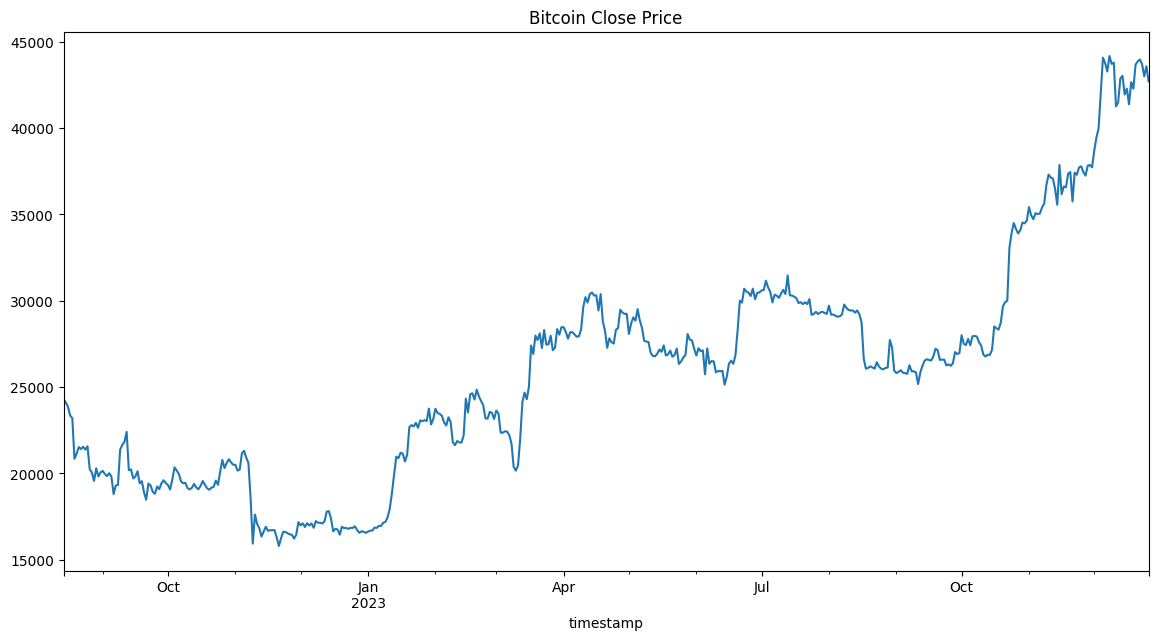

In [72]:
btc_data['close'].plot(figsize=(14, 7), title="Bitcoin Close Price")

In [73]:
#  Feature Engineering (Using close prices only for simplicity)
data = btc_data[['close']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [74]:
# Create a function to create sequences for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, y = create_dataset(data_scaled, time_step)

In [75]:
# Split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [76]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [77]:
# Model Building
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

267/267 [==============================] - 27s 85ms/step - loss: 0.0049


In [79]:
#Model Evaluation
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 37ms/step


In [80]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [81]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')


Train RMSE: 25143.96688959118, Test RMSE: 32126.676070937865


1/1 [==============================] - 0s 29ms/step


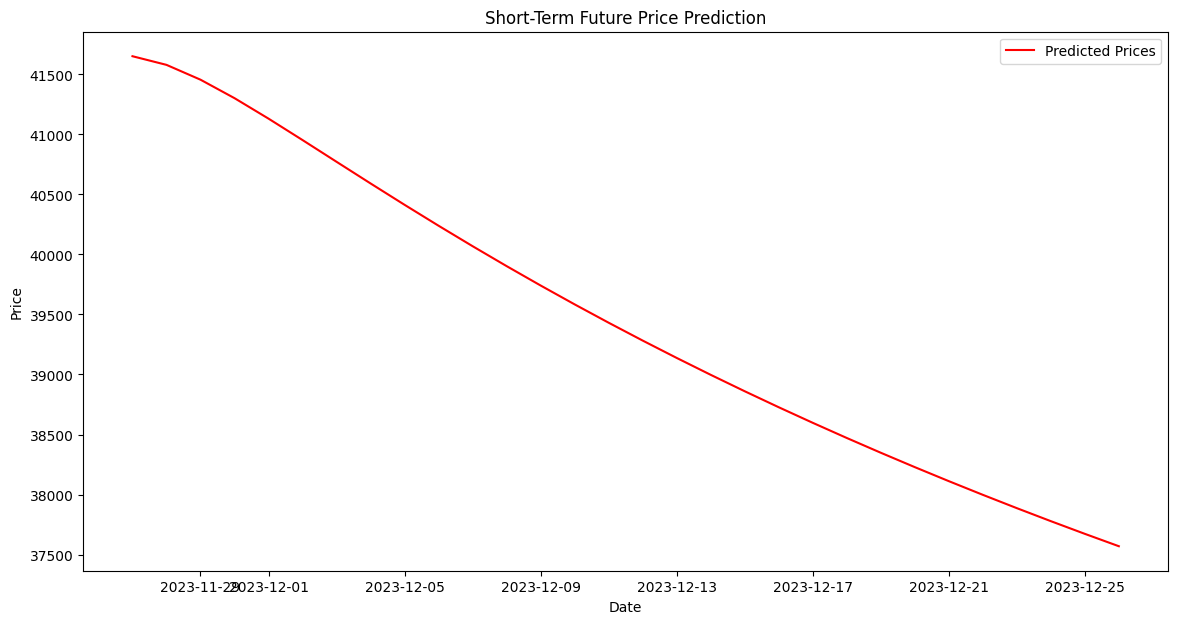

In [82]:
import numpy as np

# Function to predict future prices
def predict_future_prices(model, last_100_days, future_days):
    future_predictions = last_100_days
    for _ in range(future_days):
        x = future_predictions[-100:]
        x = x.reshape((1, 100, 1))
        future_price = model.predict(x)
        future_predictions = np.append(future_predictions, future_price)
    return future_predictions[-future_days:]

# Predict the next 30 days (as an example for short-term prediction)
last_100_days = data_scaled[-100:]
future_days = 30
future_predictions = predict_future_prices(model, last_100_days, future_days)

# Transform predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[-future_days:], future_predictions, color='red', label='Predicted Prices')
plt.title('Short-Term Future Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


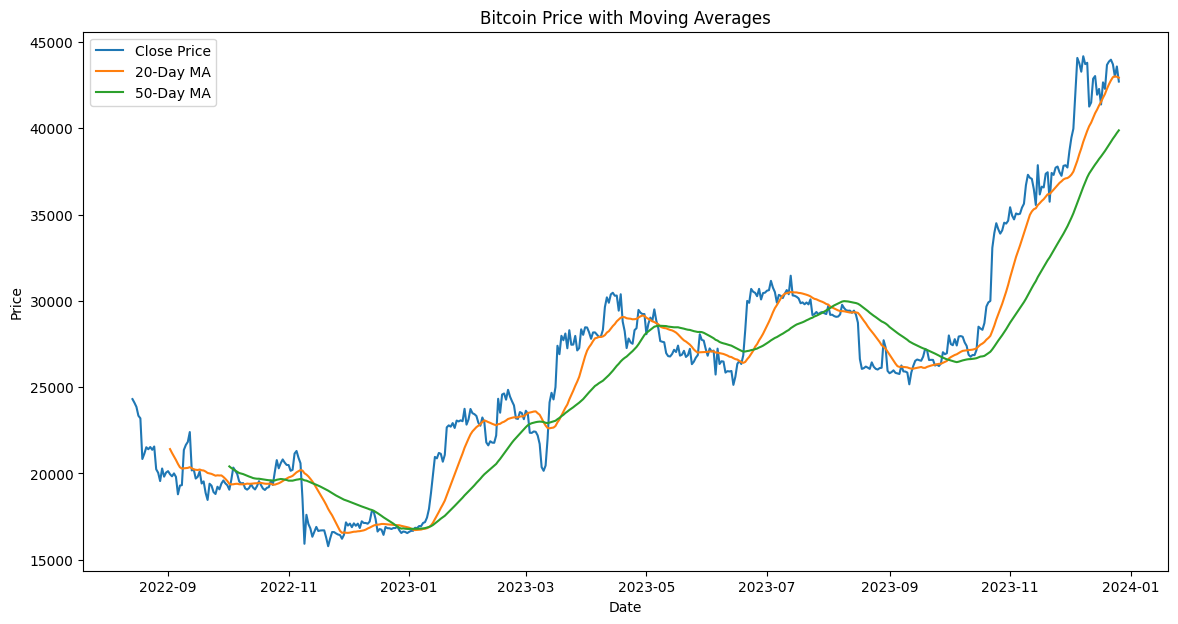

In [84]:
# Calculate moving averages
btc_data['MA20'] = btc_data['close'].rolling(window=20).mean()
btc_data['MA50'] = btc_data['close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(btc_data['close'], label='Close Price')
plt.plot(btc_data['MA20'], label='20-Day MA')
plt.plot(btc_data['MA50'], label='50-Day MA')
plt.title('Bitcoin Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


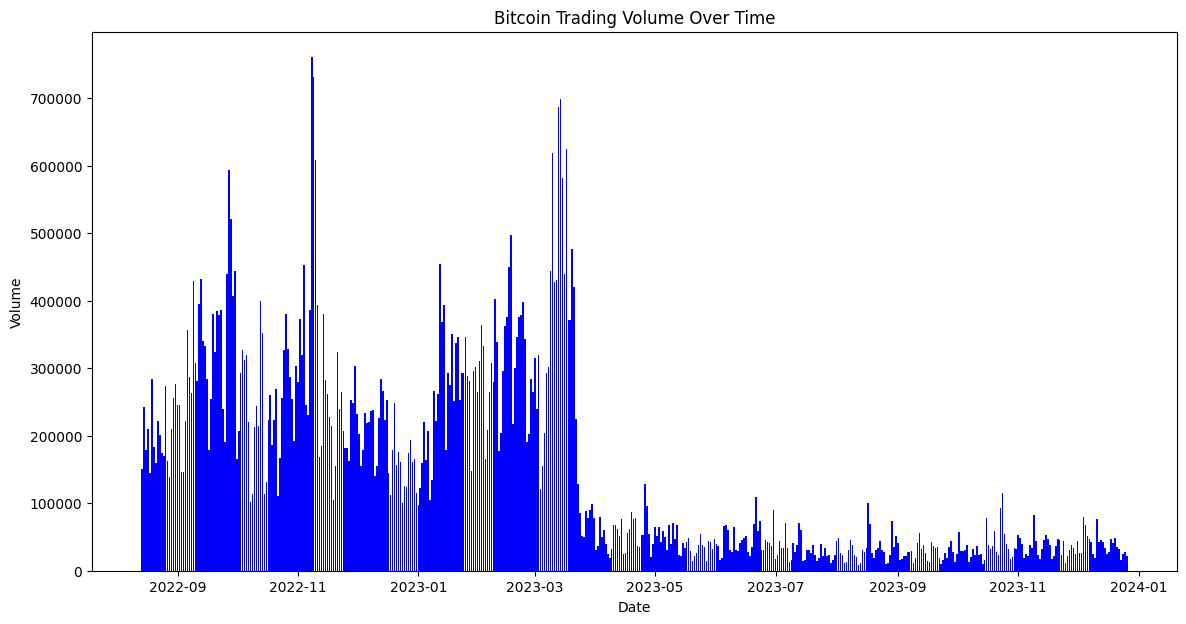

In [87]:
plt.figure(figsize=(14, 7))
plt.bar(btc_data.index, btc_data['volume'], color='blue')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


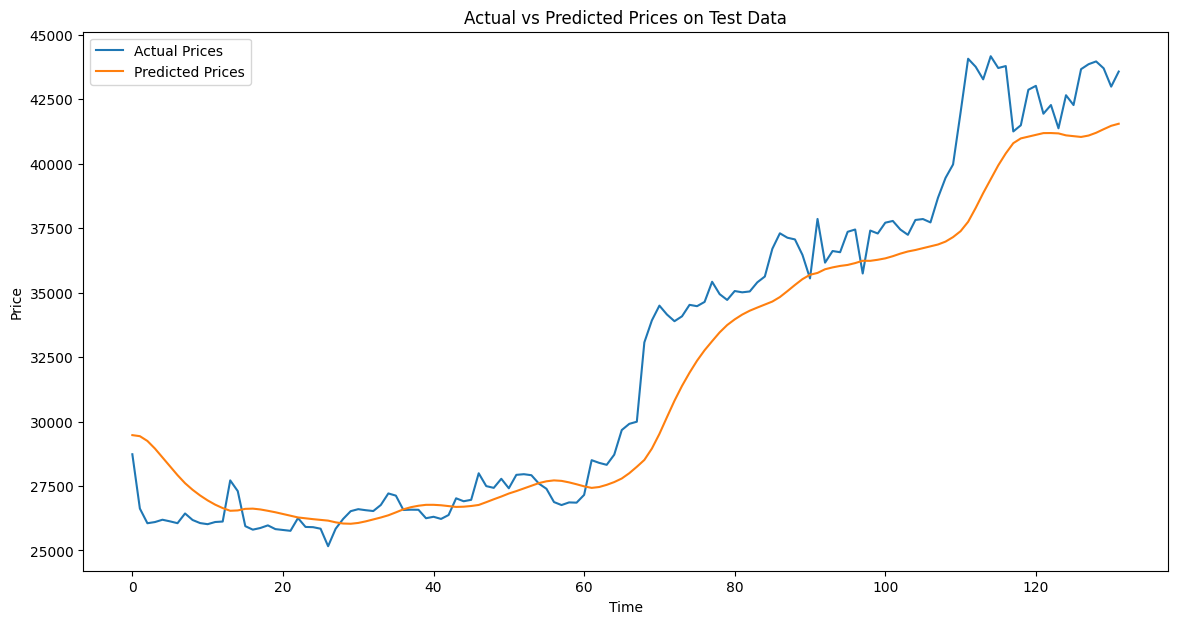

In [88]:
# Assuming test_predict and y_test are from the previous example
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(test_predict, label='Predicted Prices')
plt.title('Actual vs Predicted Prices on Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


<ipython-input-89-b780526cf770>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=btc_data.index[-1], periods=future_days + 1, closed='right')


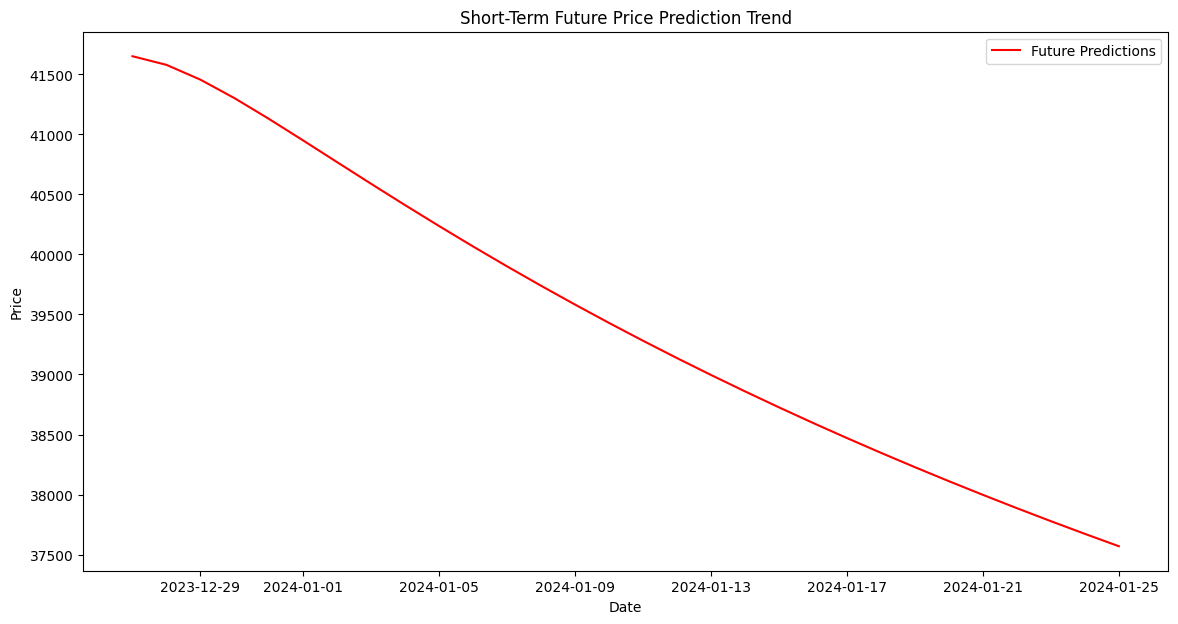

In [89]:
# Assuming future_predictions are from the previous example
future_dates = pd.date_range(start=btc_data.index[-1], periods=future_days + 1, closed='right')

plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, color='red', label='Future Predictions')
plt.title('Short-Term Future Price Prediction Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
